Dataset shape: (1080, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       1080 non-null   object 
 1   gdp           1080 non-null   float64
 2   unemployment  1080 non-null   float64
 3   youth_pct     1080 non-null   float64
 4   internet_pct  1080 non-null   float64
 5   polity        1080 non-null   float64
 6   date          1080 non-null   object 
 7   year          1080 non-null   int64  
 8   month         1080 non-null   int64  
 9   label         1080 non-null   int64  
 10  prev_events   1080 non-null   int64  
 11  log_gdp       1080 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 101.4+ KB

First 5 rows:

Missing values per column:
country         0
gdp             0
unemployment    0
youth_pct       0
internet_pct    0
polity          0
date            0
year            0

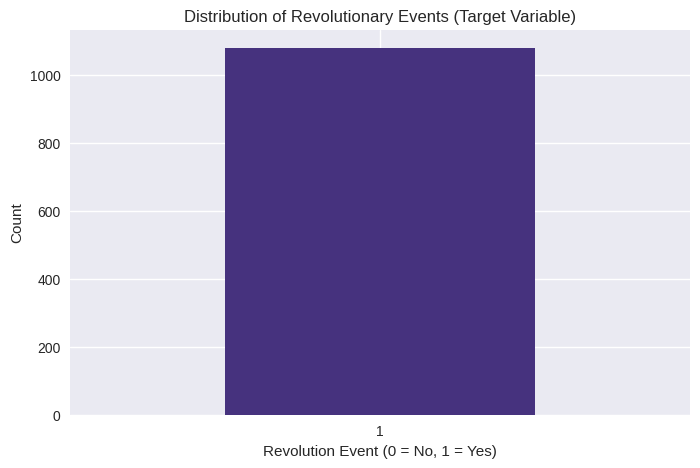

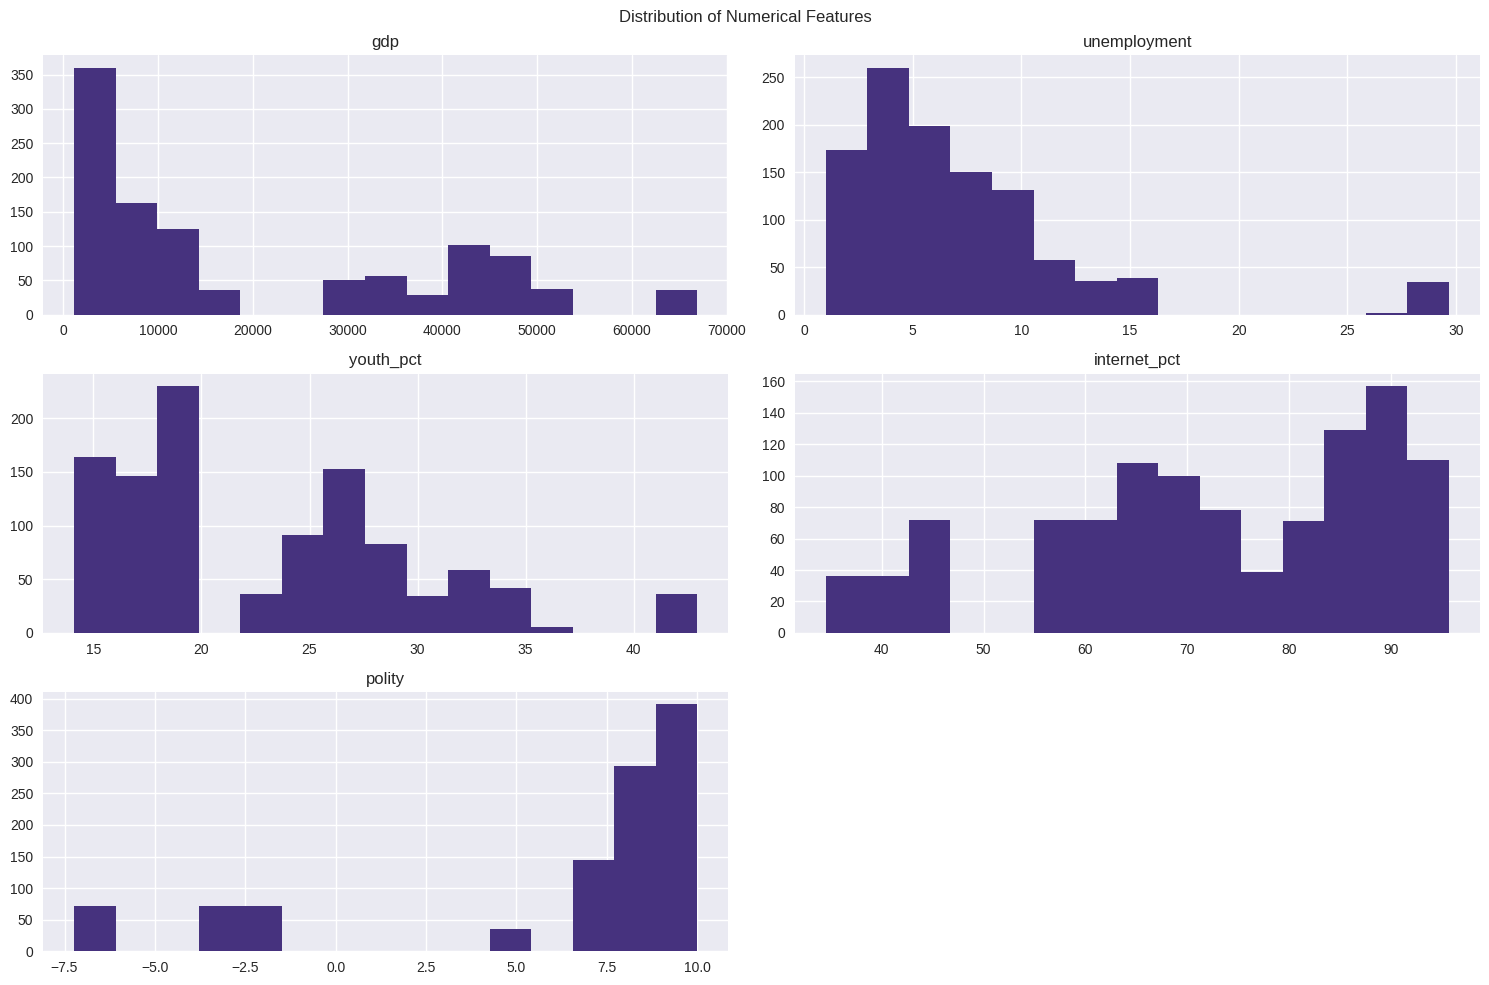

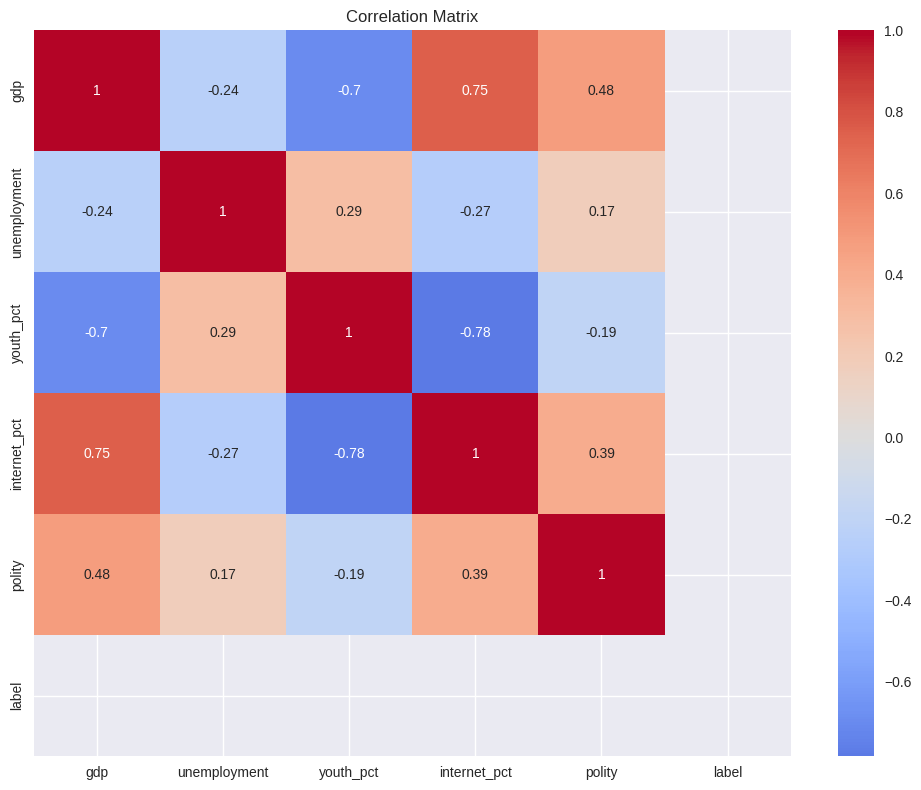

Class distribution:
label
1    1080
Name: count, dtype: int64

Percentage of positive cases: 100.00%
Downsampling majority class...
No minority class examples found. Creating some synthetic negative examples.
New class distribution:
1    1080
0      50
Name: count, dtype: int64
Training set size: 724
Test set size: 406
Data preprocessing completed! Files saved to data/ folder.


In [1]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

# # Revolution Risk Predictor - Data Preprocessing
# 
# This notebook handles data loading, cleaning, and preprocessing for the revolution risk prediction model.

# ## Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# ## Load and Explore Data

# Load the dataset
df = pd.read_csv('../data/revolution_risk_data.csv')
print(f"Dataset shape: {df.shape}")

# Display basic information
print("\nDataset Info:")
df.info()

# Display first few rows
print("\nFirst 5 rows:")
df.head()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check basic statistics
print("\nDescriptive statistics:")
df.describe()

# ## Data Visualization

# Distribution of target variable
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Revolutionary Events (Target Variable)')
plt.xlabel('Revolution Event (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Distribution of numerical features
numerical_features = ['gdp', 'unemployment', 'youth_pct', 'internet_pct', 'polity']
df[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features + ['label']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ## Data Preprocessing

# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Convert date to datetime and extract time-based features
df_processed['date'] = pd.to_datetime(df_processed['date'])
df_processed['year'] = df_processed['date'].dt.year
df_processed['month'] = df_processed['date'].dt.month
df_processed['quarter'] = df_processed['date'].dt.quarter

# Create log transformation of GDP to handle skewness
df_processed['log_gdp'] = np.log1p(df_processed['gdp'])

# Create previous events feature (lag by 1 month)
df_processed = df_processed.sort_values(['country', 'date'])
df_processed['prev_events'] = df_processed.groupby('country')['label'].shift(1).fillna(0)

# Define feature columns
feature_cols = ['log_gdp', 'unemployment', 'youth_pct', 'internet_pct', 'polity', 'prev_events']
target_col = 'label'

# Split features and target
X = df_processed[feature_cols]
y = df_processed[target_col]

# Check class balance
print("Class distribution:")
print(y.value_counts())
print(f"\nPercentage of positive cases: {y.mean()*100:.2f}%")

# Handle class imbalance - Alternative approach without SMOTE
if y.mean() > 0.8:  # If we have too many positive cases
    print("Downsampling majority class...")
    from sklearn.utils import resample
    
    # Combine X and y
    data = pd.concat([X, y], axis=1)
    
    # Separate majority and minority classes
    majority = data[data[target_col] == 1]
    minority = data[data[target_col] == 0]
    
    if len(minority) > 0:
        # Downsample majority class
        majority_downsampled = resample(majority,
                                        replace=False,  # without replacement
                                        n_samples=len(minority),  # to match minority class
                                        random_state=42)
        
        # Combine minority class with downsampled majority class
        data_balanced = pd.concat([majority_downsampled, minority])
        
        # Split back into X and y
        X = data_balanced[feature_cols]
        y = data_balanced[target_col]
    else:
        print("No minority class examples found. Creating some synthetic negative examples.")
        # Create a few negative samples by slightly modifying positive samples
        X_neg = X.sample(n=min(50, len(X)), random_state=42).copy()
        for col in X.columns:
            if col != 'prev_events':  # Don't modify the prev_events too much
                X_neg[col] = X_neg[col] * (1 + np.random.normal(0, 0.1, size=len(X_neg)))
        y_neg = pd.Series([0] * len(X_neg))
        
        # Add to original data
        X = pd.concat([X, X_neg])
        y = pd.concat([y, y_neg])

print("New class distribution:")
print(y.value_counts())

# Split into training and testing sets (time-based split)
latest_date = df_processed['date'].max()
test_start = latest_date - pd.DateOffset(months=12)
train_mask = df_processed['date'] < test_start
test_mask = df_processed['date'] >= test_start

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save processed data and scaler
import joblib

pd.DataFrame(X_train_scaled, columns=feature_cols).to_csv('../data/X_train.csv', index=False)
pd.DataFrame(X_test_scaled, columns=feature_cols).to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)
joblib.dump(scaler, '../models/scaler.joblib')

print("Data preprocessing completed! Files saved to data/ folder.")